# Hands on with YOLO (Ultralytics)
Ultralytics is a user-friendly library that provides easy training, inference and exporting of YOLO-series models. However, exporting is mostly used for high-throughput industrial applications or edge deployment (e.g. INT4 quantization, TensorRT acceleration). For learning purposes, they are not necessary.

To install, run `pip install -U ultralytics`

# Training
## Preparing dataset
To start training, we first need to prepare the dataset files.

Ultralytics expects a format commonly called "YOLO format", which is different from "COCO format" that some other libraries use (and what you may be given in). COCO format is in JSON while YOLO format is in txt. There are conversion scripts to convert from JSON to YOLO here: https://github.com/ultralytics/JSON2YOLO. Instructions are included.

The YOLO format requires that:
1. Images to be placed separately in a subfolder that follows the pattern `<dataset_root>/<split>/images`
2. Labels to be placed separately in a subfolder that follows the pattern `<dataset_root>/<split>/labels`
3. For each image in the images folder (e.g. image_1.png, image_2.png...), there must be a corresponding txt file named the same in the labels folder (e.g. image_1.txt, image_2.txt)
4. Each txt file contains one of more lines that represent all bounding boxes in that image. Each line is in `class_id x_center y_center width height` format, where xywh are normalized between 0 and 1. If your labels are not normalized, you should divide x_center and width by image width, and y_center and height by image height.
Example of a label txt file:
```text
0 0.6157894736842106 0.27586206896551724 0.031578947368421054 0.17471264367816092
0 0.6868421052631579 0.10804597701149425 0.015789473684210527 0.03218390804597701
0 0.4881578947368421 0.6206896551724138 0.05 0.0735632183908046
0 0.3815789473684211 0.16091954022988506 0.07368421052631578 0.05517241379310345
```

Note that both `dataset_root` and `split` can be set by you and not necessarily "train"/"val" etc.

Then, we need to prepare the dataset config YAML, which specifies your `dataset_root` and split names. We will use the `%%writefile` magic command here to write the config file, but you can also just copy and paste using any text editor.

The config file below set the dataset_root as "dataset", and specified train split to be called "train" and val split to be called "val". Thus, the directory structure should look like:
```text
dataset
    ├───train
    │   ├───images
    │   └───labels
    └───val
        ├───images
        └───label
```

The config file also specifies the classes and their names. Make sure the class id you provide there correctly matches with the txt labels.

Take note that `dataset_root` has to be ABSOLUTE path for it to work correctly. Setting it to relative path will cause Ultralytics to assume the dataset is under another folder. Below we will use `os.getcwd()` to get it then remember to change the cell writing the config file before you proceed.

In [ ]:
import os
os.getcwd()  # get the absolute path

In [3]:
%%writefile til.yaml
path: <insert your absolute path from os.getcwd()>/dataset  # dataset_root dir
train: train  # train split (relative to 'path' or dataset_root)
val: val  # val split (relative to 'path' or dataset_root)

# Classes
names:
  0: target

Overwriting til.yaml


## Actual training
Now we can finally load the model and train it. The training materials includes a small dataset consisting of 2 images in train split and 1 image in val split to demonstrate the training process.

We will always start with a pre-trained model so that we can leverage the pretraining to do transfer learning. For speed of demonstration we will choose the smallest model in the YOLOv11 series, but feel free to change to a larger one for better accuracy.

There are a lot of hyperparameters one can tune for training. Commonly used ones are:
- epochs: number of times your model sees the entire dataset. The higher the value the longer the training. If it is too much, it can memorize the training data and thus overfit.
- imgsz: the input size of the image. In general, the larger it is the more accurate a model can get, since it has more information to work with. Note that all input images will be resized to a square with each side equal to this dimension. Thus, the maximum value that makes sense would be the longest side of your input image, as going beyond that will give no additional information to the model. Compute costs scale quadratically with imgsz (both training and inference) so be sure to balance that out. The default size YOLO models are trained on is 640px, and in some larger models it use 1280px. Starting with 640px is always a good baseline.
- single_cls: used to control if your dataset only contain a single class to detect
- save: control whether to save checkpoints to resume from. Should always be turned on to reduce risk of losing training progress. However, watch the available storage space closely as it saves every epoch by default (can be controlled by save_period)
- batch: batch size to train. Generally set this to the maximum that your GPU can handle without out of memory (OOM) error. A larger batch size increases training throughput and also stability. Ultralytics also allow you to set to "-1" which is equal to automatically finding the batch size with 60% VRAM usage. Setting to any other float will be equal to finding that with X% usage. e.g. 0.8 = 80% VRAM usage.
- patience: control the number of epoch to wait before terminating the training early (early-stopping). This monitors the performance of the model on validation split and if it does not improve for more than X epochs, it stops the training as this means the model has reached a state where it no longer improves. Early stopping prevents overfitting.
- save_period: controls frequency of saving checkpoints (to save every X epoch)
- cos_lr: use the cosine decay learning rate scheduler. Generally recommended.
- workers: specify the dataloader workers for preprocessing. A higher value uses more CPU cores and also more RAM. Often, setting this to be same as your CPU cores will cause you to run out of system RAM. Increment this value carefully to prevent system crashing.
- plots: whether to visualize some augmented dataset sample and metrics. Useful to debug performance issues.
- resume: if there are checkpoints saved in the previous training run, this can automatically find the checkpoint and resume from it. If you want to resume from a particular checkpoint, then load that first using `YOLO('checkpoint_name.pt')`.

For a full list of arguments, check https://docs.ultralytics.com/modes/train/#train-settings

One can also change the augmentation settings when calling `model.train`. Available arguments: https://docs.ultralytics.com/modes/train/#augmentation-settings-and-hyperparameters

In [ ]:
from ultralytics import YOLO
model = YOLO('yolo11n.pt')

results = model.train(data="til.yaml", epochs=1, imgsz=640, single_cls=True, save=True, batch=2, patience=5, save_period=1, cos_lr=True, workers=1, plots=True, resume=False)

If you want to add your own augmentation, the easiest (but hacky) way is to modify the ultralytics library itself. First, find the path of the ultralytics library, then use any text editor to edit the file responsible for augmentation. Then, reload your jupyter notebook kernel.

In [7]:
import ultralytics
print(ultralytics)  # shows the absolute path to ultralytics library code

<module 'ultralytics' from 'C:\\Program Files\\Python39\\lib\\site-packages\\ultralytics\\__init__.py'>


Edit the code found at https://github.com/ultralytics/ultralytics/blob/c1512e5be6968c72e303e0c3926b56372bf93e9c/ultralytics/data/augment.py#L1848, or <root to ultralytics package>/data/augment.py around line 1848:

```python
T = [
    A.Blur(p=0.01),
    A.MedianBlur(p=0.01),
    A.ToGray(p=0.01),
    A.CLAHE(p=0.01),
    A.RandomBrightnessContrast(p=0.0),
    A.RandomGamma(p=0.0),
    A.ImageCompression(quality_range=(75, 100), p=0.0),
]
```

You can add your own Transforms from `albumentations` package, or write your own transforms. You can also adjust the intensity/parameters of existing transforms. Remember however that if the augmentation is too strong, the model may not learn it well, especially for smaller variants.

# Inference
Object detection models have some parameters one can tune for inference, depending on the importance of precision and recall. Commonly tuned parameters include:
- Confidence Threshold (conf): The minimum confidence level required for a detection to be considered valid. Increase this when false positive is more impactful than false negative.
- IoU Threshold (iou): The minimum intersection over union (IoU) required for a detection to be considered a true positive. Increase this when false positive is more impactful than false negative.

These attributes can be set when calling `model.predict()`.

Since we only trained on 2 images, our trained checkpoint would not work. Thus we will demonstrate inference using the pretrained model.

In [5]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolo11n.pt')  # load an official model
# model = YOLO('runs/detect/train/best.pt')  # load a custom model

# Predict with the model
results = model.predict(['https://ultralytics.com/images/bus.jpg'], iou=0.3, conf=0.5)

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    probs = result.probs  # Probs object for classification outputs
    result.save(filename='result.jpg')  # save the visualized result
    # result.show()  # display to screen, does not work on a cloud VM/Vertex AI/Colab


0: 640x480 4 persons, 1 bus, 59.0ms
Speed: 2.2ms preprocess, 59.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


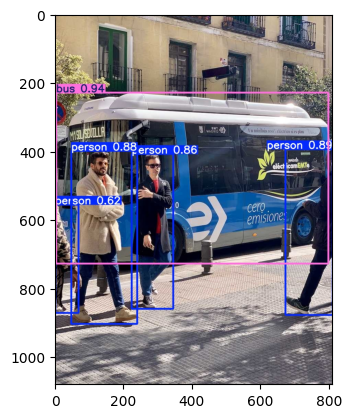

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(Image.open('result.jpg'))
plt.show()